In [1]:
pretrained_base = './pretrained/'
precomputed_base = './precomputed/'
data_base = '../data/'

In [2]:
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import torch
import torch.nn as nn

import argparse
from torch.serialization import default_restore_location

import os
import sys  
import models
from skimage import io
import pickle

import utils

%matplotlib inline

In [3]:
# Datasets available in the data folder
train_folder_path = os.path.join(data_base, 'Train400/')
test_folder_path = os.path.join(data_base, 'Test/Set68/')
set12_path = os.path.join(data_base, 'Test/Set12/')
kodak_path = os.path.join(data_base, 'Test/Kodak23/') 

In [4]:
USE_CUDA = True

device = torch.device('cuda') if (torch.cuda.is_available() and USE_CUDA) else torch.device('cpu') 

In [5]:
USE_PRECOMPUTED_METRICS = True

### Helper Functions

In [6]:
def single_image_loader(data_set_dire_path, image_number):
    all_names = os.listdir(data_set_dire_path)
    all_names.sort()
    file_name = all_names[image_number]
    im = io.imread(data_set_dire_path + file_name).astype(float)/255
    return im

In [7]:
def display_denoising(DnCNN, BF_DnCNN, set12_path, 
                      image_num=7, noise_level = 90, l = 0, h=10, model = 'DnCNN'):

    clean_im = single_image_loader(set12_path, image_num)
    clean_im_tensor = torch.from_numpy(clean_im).unsqueeze(0).unsqueeze(0).to(device).float()

    noise = utils.get_noise(clean_im_tensor, noise_std = noise_level/255., mode='S')
    inp_test = clean_im_tensor + noise;
    noisy_psnr = np.round(utils.psnr(clean_im_tensor, inp_test), 2) 
    noisy_ssim = np.round(utils.ssim(clean_im_tensor, inp_test), 2)

    denoised_dncnn= DnCNN(inp_test)
    denoised_dncnn_psnr = np.round(utils.psnr(clean_im_tensor, denoised_dncnn), 2)
    denoised_dncnn_ssim = np.round(utils.ssim(clean_im_tensor, denoised_dncnn), 2)
    denoised_dncnn = denoised_dncnn.cpu().data.squeeze(0).squeeze(0).numpy()
    
    denoised_bf_dncnn= BF_DnCNN(inp_test)
    denoised_bf_dncnn_psnr = np.round(utils.psnr(clean_im_tensor, denoised_bf_dncnn), 2)
    denoised_bf_dncnn_ssim = np.round(utils.ssim(clean_im_tensor, denoised_bf_dncnn), 2)
    denoised_bf_dncnn = denoised_bf_dncnn.cpu().data.squeeze(0).squeeze(0).numpy()
    noisy_im = inp_test.cpu().data.squeeze(0).squeeze(0).numpy()

    f, axs = plt.subplots(1,4, figsize = (15,4), squeeze=True)

    f.suptitle(r'Training range: $\sigma \in [ $' + str(l) +' , '+ str(h) + ']',  fontname= 'Times New Roman', fontsize = 15)

    axs[0].imshow(clean_im, 'gray', vmin= 0, vmax = 1)
    axs[0].set_title('clean image', fontname= 'Times New Roman', fontsize = 15)

    axs[1].imshow(noisy_im, 'gray', vmin= 0, vmax = 1)
    axs[1].set_title(r'noisy image, $\sigma$ = '+str(noise_level), fontname= 'Times New Roman', fontsize = 15)
    axs[1].set_xlabel('psnr ' +str(noisy_psnr) + '\n ssim '+str(noisy_ssim), fontname= 'Times New Roman', fontsize = 15)

    axs[2].imshow(denoised_dncnn, 'gray', vmin= 0, vmax = 1)
    axs[2].set_title('denoised, '+model, fontname= 'Times New Roman', fontsize = 15)
    axs[2].set_xlabel('psnr ' +str(denoised_dncnn_psnr)+'\n ssim '+str(denoised_dncnn_ssim), fontname= 'Times New Roman', fontsize = 15)

    axs[3].imshow(denoised_bf_dncnn, 'gray', vmin= 0, vmax = 1)
    axs[3].set_title('denoised, BF_'+model, fontname= 'Times New Roman', fontsize = 15)
    axs[3].set_xlabel('psnr ' +str(denoised_bf_dncnn_psnr)+'\n ssim '+str(denoised_bf_dncnn_ssim), fontname= 'Times New Roman', fontsize = 15)

    for i in range(4): 
        axs[i].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)


In [8]:
def load_model(checkpoint_path):
    state_dict = torch.load(checkpoint_path, map_location=lambda s, l: default_restore_location(s, "cpu"))
    args = argparse.Namespace(**{ **vars(state_dict["args"]), "no_log": True})

    model = models.build_model(args).to(device)
    model.load_state_dict(state_dict["model"][0])
    model.eval()
    return model

In [9]:
def display_performance_plot(metrics_dncnn, metrics_bfcnn, model, l, h):
   
    f , axs = plt.subplots(1,2, figsize=(14,7))
    #### PSNR
    x_axis = metrics_dncnn['psnr'] - metrics_dncnn['psnr_delta']
    axs[0].plot( [8,30],[8,30] ,'k--', alpha = 1, label = 'identity');
    axs[0].set_xticklabels(np.round(x_axis).astype(int) ,rotation=90, fontsize=13, fontname= 'Times New Roman')
    axs[0].set_yticklabels(np.round(x_axis).astype(int) , fontsize=13, fontname= 'Times New Roman');
    axs[0].set_xlabel('Input PSNR (dB)', fontsize=15, fontname= 'Times New Roman')
    axs[0].set_ylabel('Output PSNR (dB)', fontsize=15, fontname= 'Times New Roman')        
    axs[0].plot(x_axis, metrics_dncnn['psnr'], color = 'red', marker = '.',markersize = 10, label = model)
    axs[0].plot(x_axis, metrics_bfcnn['psnr'], color = 'blue', marker = '.',markersize = 10, label = 'BF_'+model)
    axs[0].set_xticks(x_axis)
    axs[0].set_yticks(x_axis)
    axs[0].grid(linewidth=1)
    if l != 0:
        axs[0].axvspan(-10*np.log10( (h/255)**2) , -10*np.log10( (l/255)**2)  , alpha=0.2, label='training range');        
    else: 
        axs[0].axvspan(-10*np.log10( (h/255)**2) , 30  , alpha=0.2, label='training range');
    axs[0].legend(fontsize = 12);

    ### SSIM
    x_axis = metrics_dncnn['ssim'] -metrics_dncnn['ssim_delta']
    axs[1].plot( [0,.8],[0,.8] ,'k--', alpha = 1, label = 'identity');
    axs[1].set_xticklabels(np.round(x_axis,2) ,rotation=90, fontsize=13, fontname= 'Times New Roman')
    axs[1].set_yticklabels(np.round(x_axis,2) , fontsize=13, fontname= 'Times New Roman');
    axs[1].set_xlabel('Input SSIM', fontsize=15, fontname= 'Times New Roman')
    axs[1].set_ylabel('Output SSIM', fontsize=15, fontname= 'Times New Roman')
    axs[1].plot(x_axis, metrics_dncnn['ssim'], color = 'red', marker = '.',markersize = 10, label = model)
    axs[1].plot(x_axis, metrics_bfcnn['ssim'], color = 'blue', marker = '.',markersize = 10, label = 'BF_'+model)
    axs[1].set_xticks(x_axis)
    axs[1].set_yticks(x_axis)
    if l != 0:
        axs[1].axvspan( x_axis[int(h/10)-1] ,x_axis[int(l/10)-1], alpha=0.2, label='training range');        
    else: 
        axs[1].axvspan( x_axis[int(h/10)-1] ,.8 , alpha=0.2, label='training range');
    axs[1].grid(linewidth=1)

    plt.show()

In [10]:
def compute_and_plot_performance_plot(model, min_noise, max_noise):
    noise_std_range = np.arange(10, 110, 10)/255.
    DnCNN = load_model(os.path.join(pretrained_base, model, 'bias', str(min_noise)+'-'+str(max_noise)+'.pt'))
    BF_DnCNN = load_model(os.path.join(pretrained_base, model, 'bias_free', str(min_noise)+'-'+str(max_noise)+'.pt'))
    
    
    os.makedirs(os.path.join(precomputed_base, model, 'bias') , exist_ok=True)
    metrics_path = os.path.join(precomputed_base, model, 'bias', str(min_noise)+'-'+str(max_noise)+'_metrics.p')

    if os.path.exists(metrics_path) and USE_PRECOMPUTED_METRICS:
        metrics_dncnn = pickle.load( open( metrics_path, "rb" ) )
    else:
        metrics_dncnn = utils.metrics_avg_on_noise_range(DnCNN, test_folder_path, 
                                                     noise_std_range, device = device )
        pickle.dump( metrics_dncnn, open(metrics_path, "wb" ) )
        
    os.makedirs(os.path.join(precomputed_base, model, 'bias_free') , exist_ok=True)
    metrics_path = os.path.join(precomputed_base, model, 'bias_free', str(min_noise)+'-'+str(max_noise)+'_metrics.p')
    if os.path.exists(metrics_path) and USE_PRECOMPUTED_METRICS:
        metrics_bfcnn = pickle.load( open( metrics_path, "rb" ) )
    else:
        metrics_bfcnn = utils.metrics_avg_on_noise_range(BF_DnCNN, test_folder_path, 
                                                     noise_std_range, device = device )
        pickle.dump( metrics_bfcnn, open(metrics_path, "wb" ) )


    display_performance_plot(metrics_dncnn, metrics_bfcnn, model, l = 0, h = max_noise)

### DnCNN

In [11]:
model = 'dncnn'
min_noise = 0

/home/sm7582/condaenvs/denoising/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


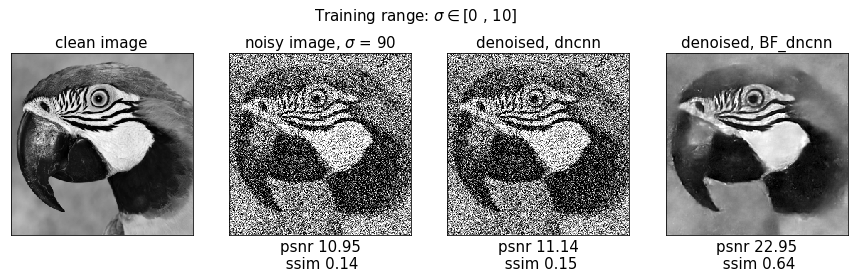

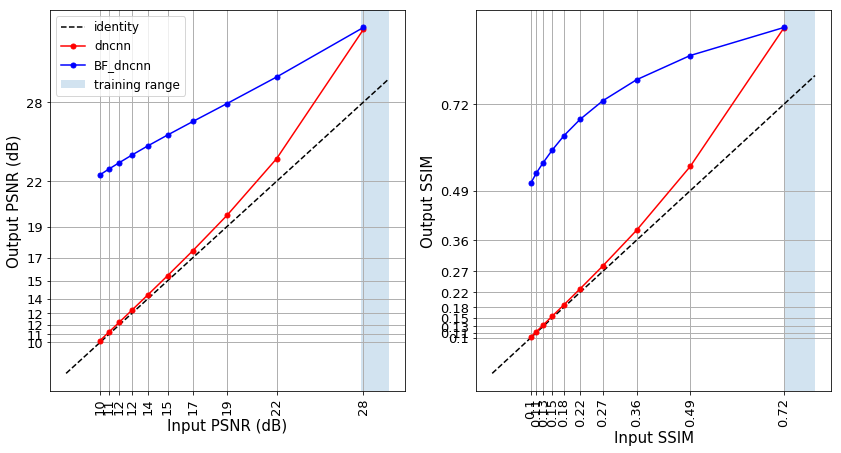

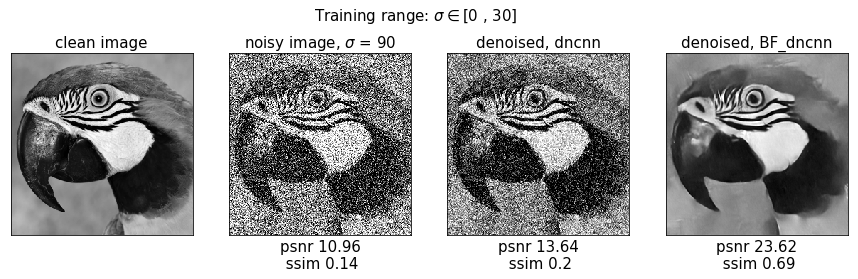

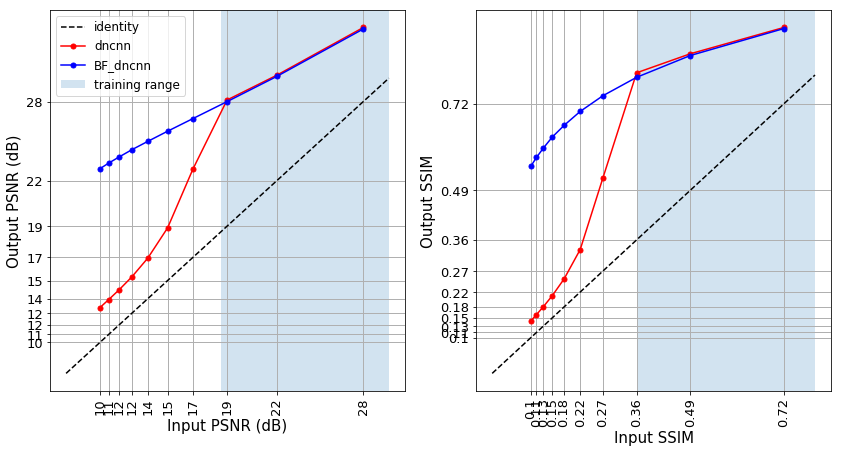

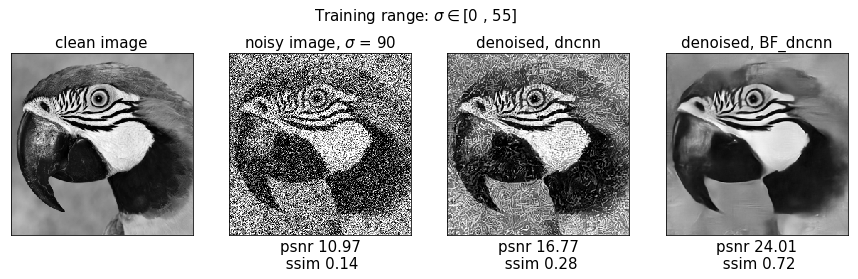

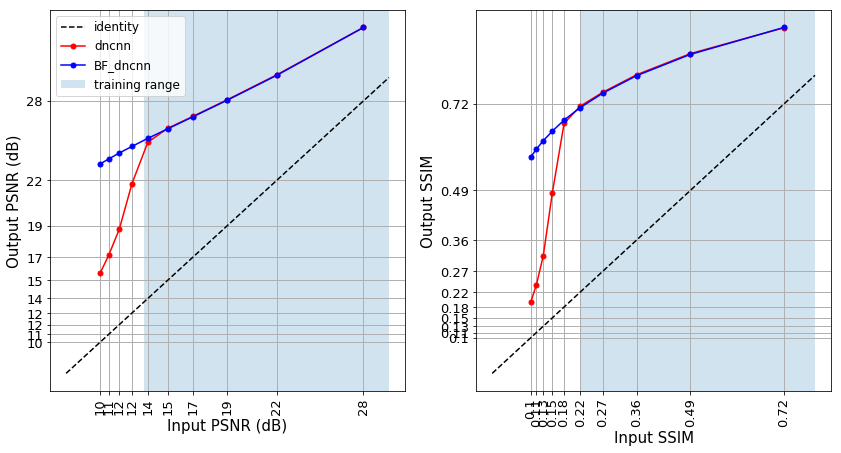

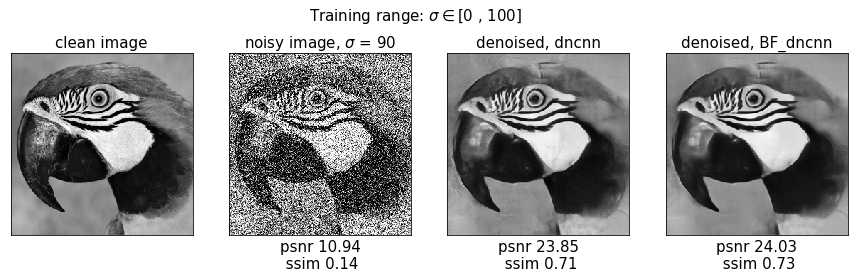

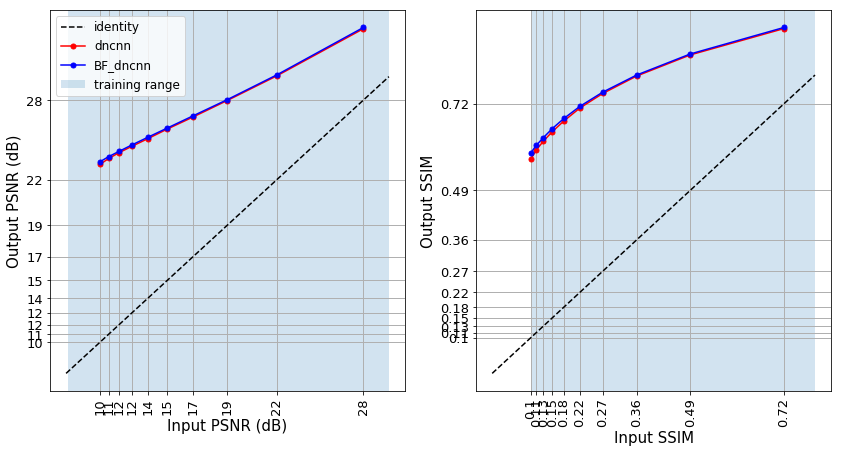

In [12]:
for max_noise in [10, 30, 55, 100]:
    DnCNN = load_model(os.path.join(pretrained_base, model, 'bias', str(min_noise)+'-'+str(max_noise)+'.pt'))
    BF_DnCNN = load_model(os.path.join(pretrained_base, model, 'bias_free', str(min_noise)+'-'+str(max_noise)+'.pt'))
    display_denoising(DnCNN, BF_DnCNN, set12_path, 
                          image_num=7, noise_level = 90, l = min_noise, h=max_noise, model = model);
    compute_and_plot_performance_plot(model, min_noise, max_noise)
    

## UNet

In [13]:
model = 'unet'
min_noise = 0

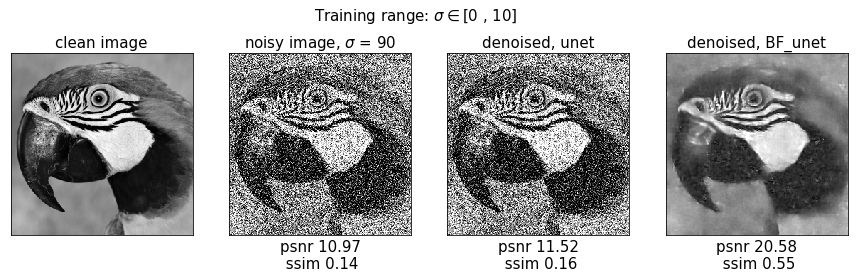

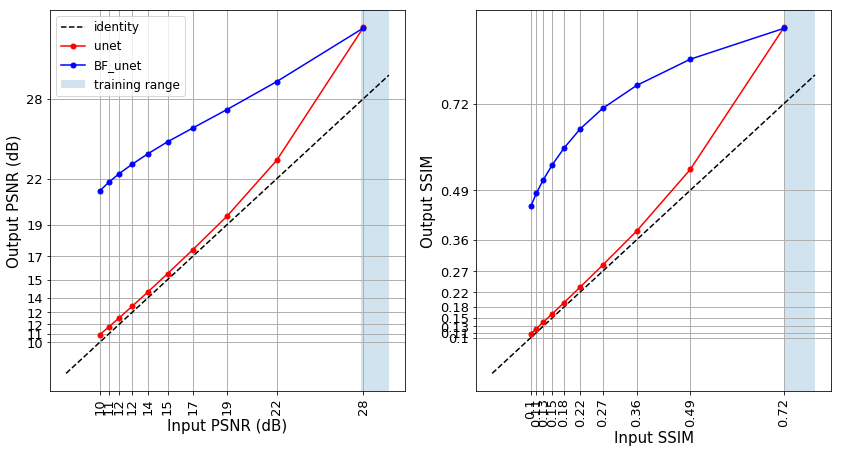

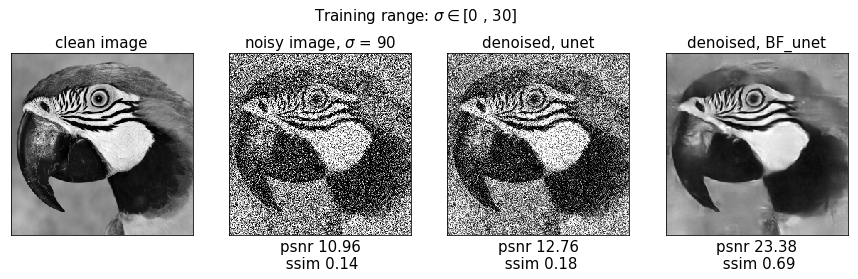

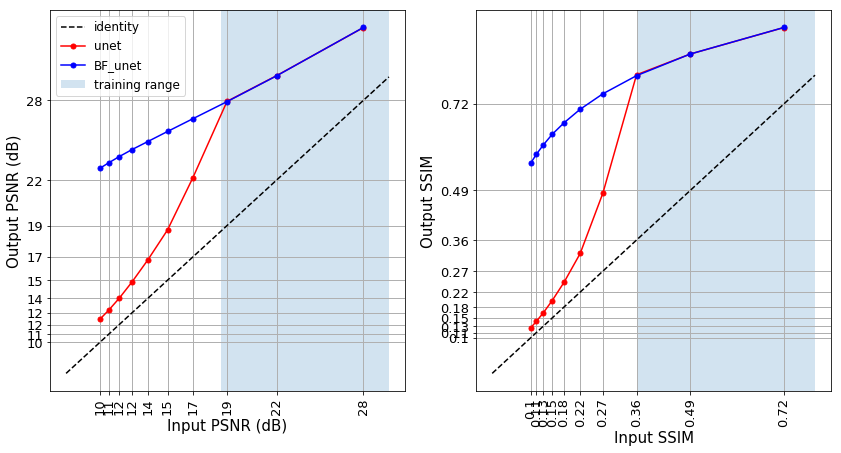

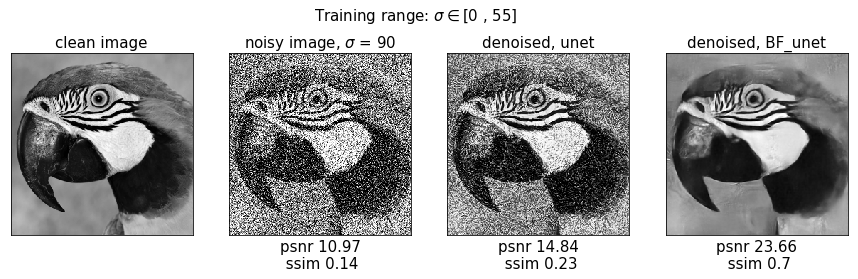

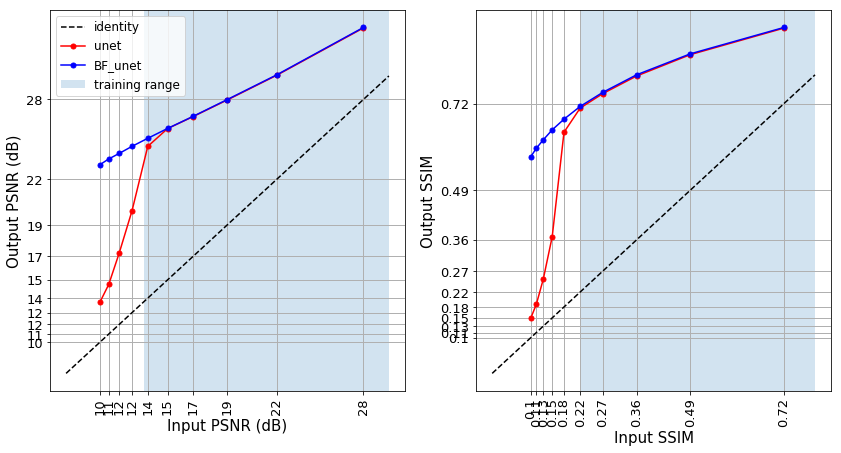

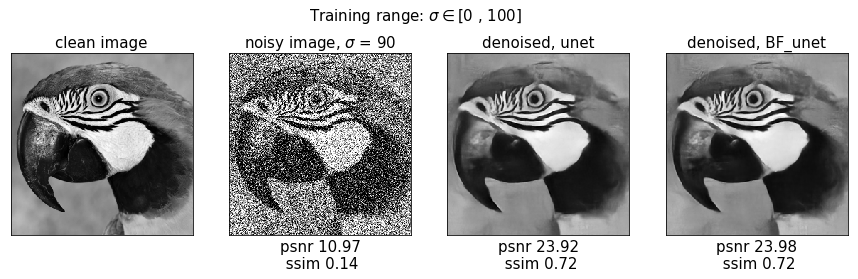

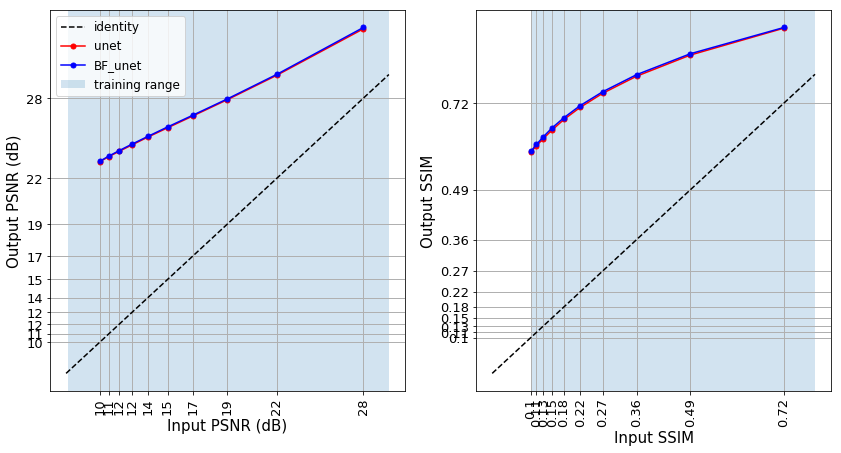

In [14]:

for max_noise in [10, 30, 55, 100]:
    CNN = load_model(os.path.join(pretrained_base, model, 'bias', str(min_noise)+'-'+str(max_noise)+'.pt'))
    BF_CNN = load_model(os.path.join(pretrained_base, model, 'bias_free', str(min_noise)+'-'+str(max_noise)+'.pt'))
    display_denoising(CNN, BF_CNN, set12_path, 
                          image_num=7, noise_level = 90, l = min_noise, h=max_noise, model = model);
    compute_and_plot_performance_plot(model, min_noise, max_noise)
    

## Recurrent CNN

In [15]:
model = 'rcnn'
min_noise = 0

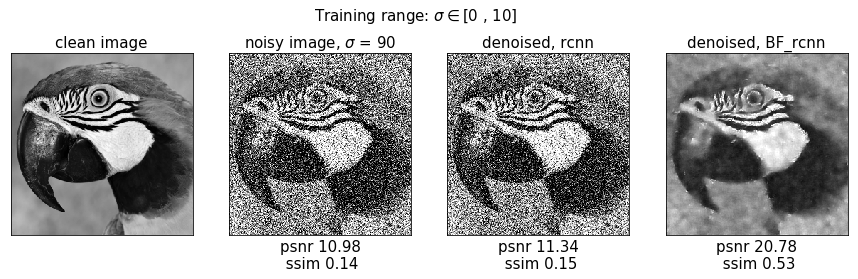

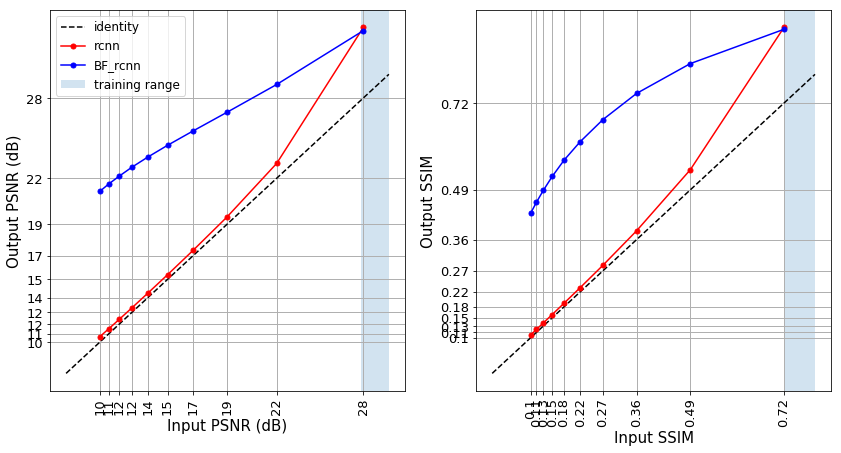

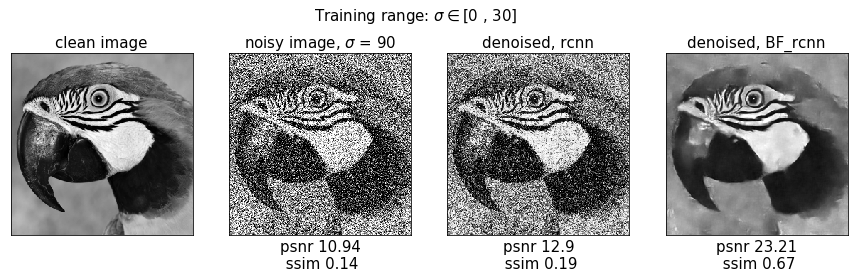

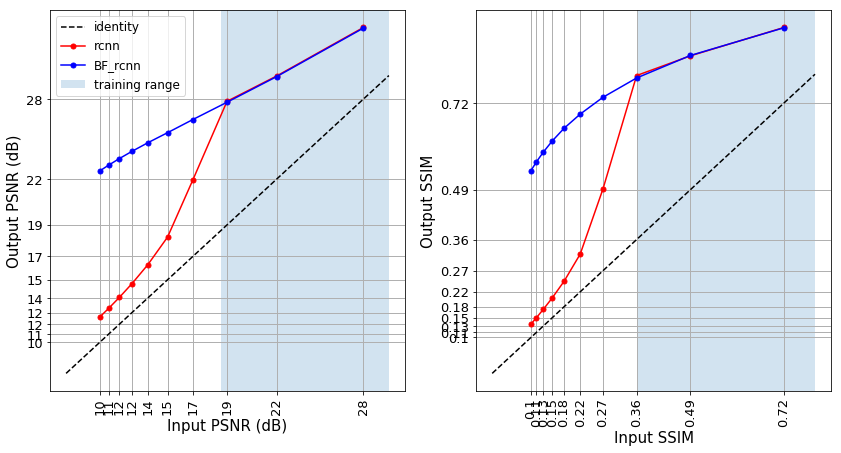

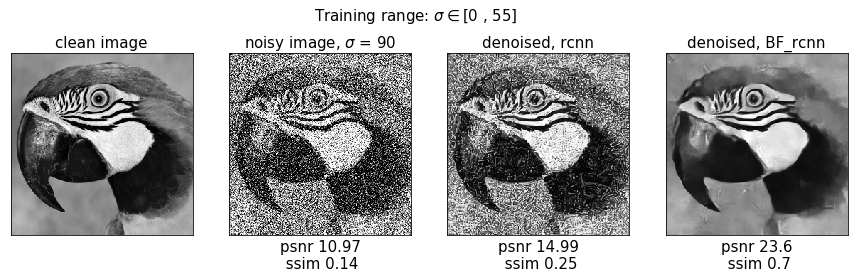

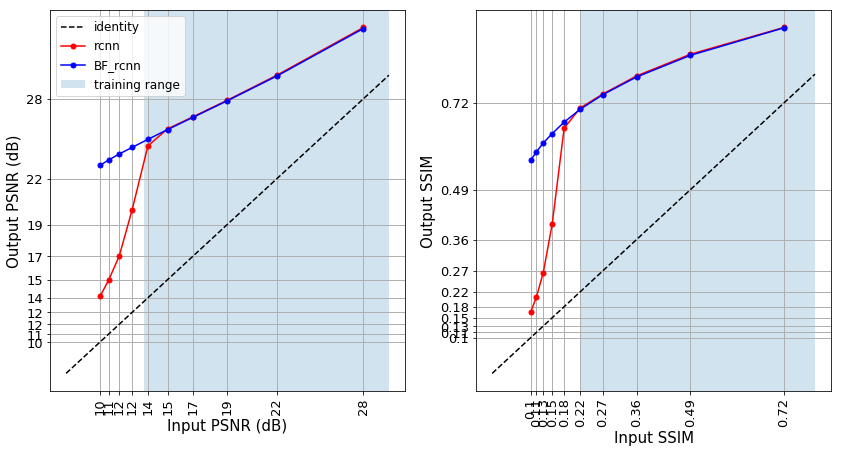

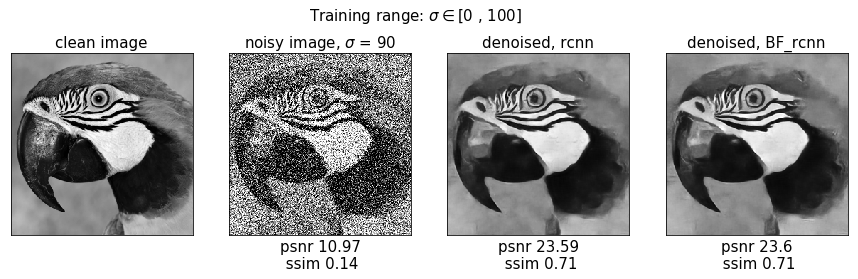

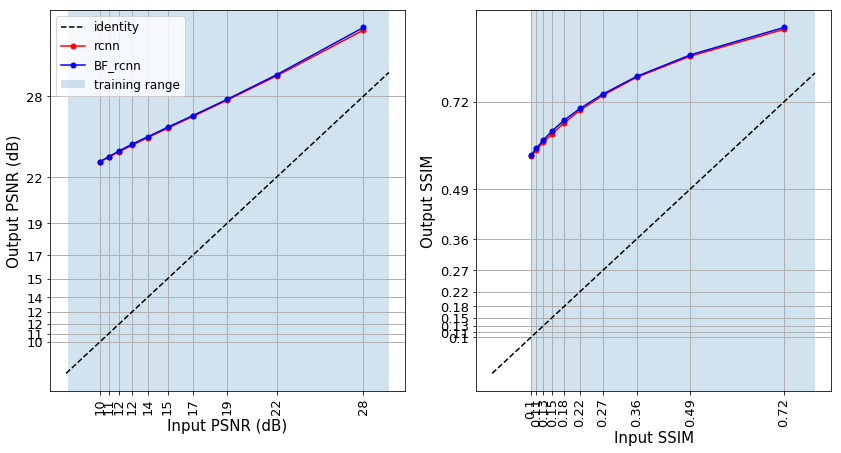

In [16]:

for max_noise in [10, 30, 55, 100]:
    CNN = load_model(os.path.join(pretrained_base, model, 'bias', str(min_noise)+'-'+str(max_noise)+'.pt'))
    BF_CNN = load_model(os.path.join(pretrained_base, model, 'bias_free', str(min_noise)+'-'+str(max_noise)+'.pt'))
    display_denoising(CNN, BF_CNN, set12_path, 
                          image_num=7, noise_level = 90, l = min_noise, h=max_noise, model=model);
    compute_and_plot_performance_plot(model, min_noise, max_noise)
    

## Simplified DenseNet

In [17]:
model = 'sdensenet'
min_noise = 0

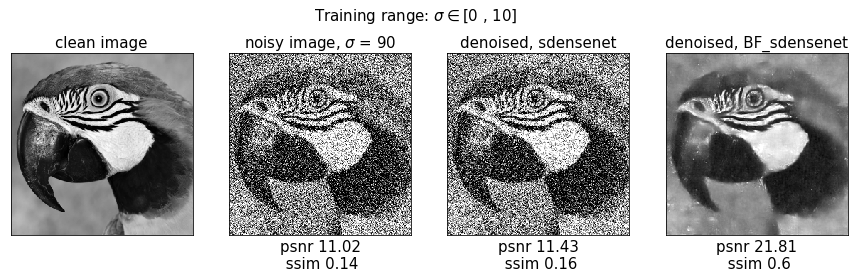

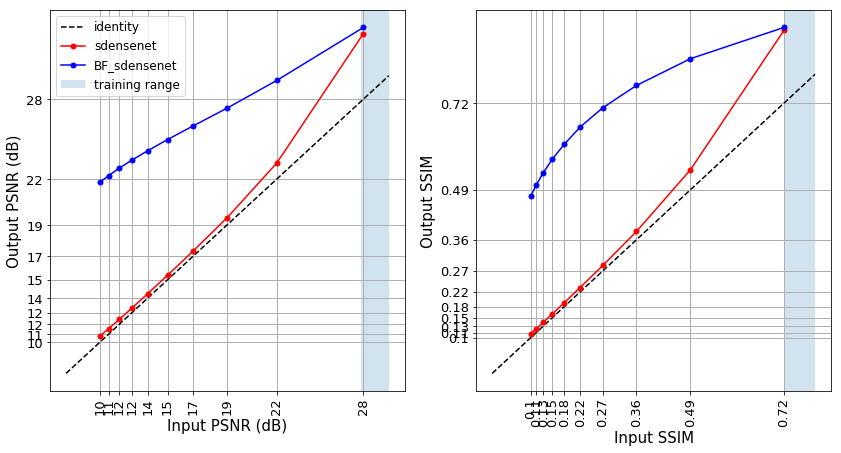

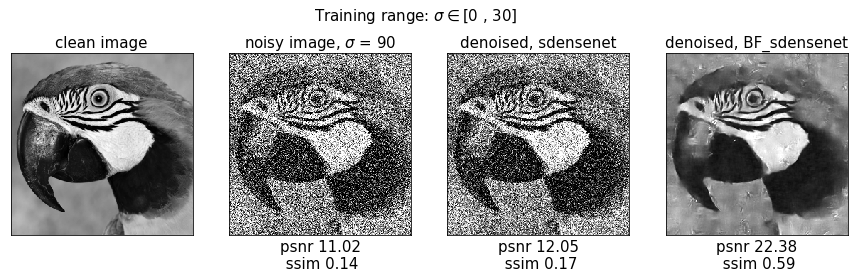

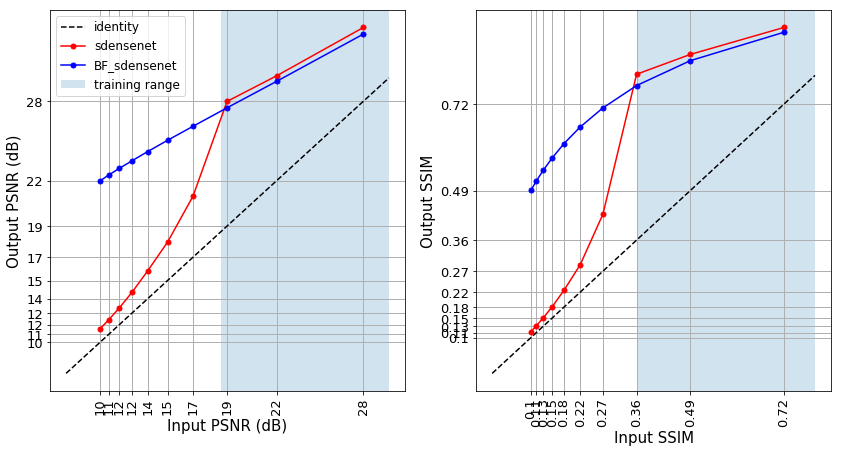

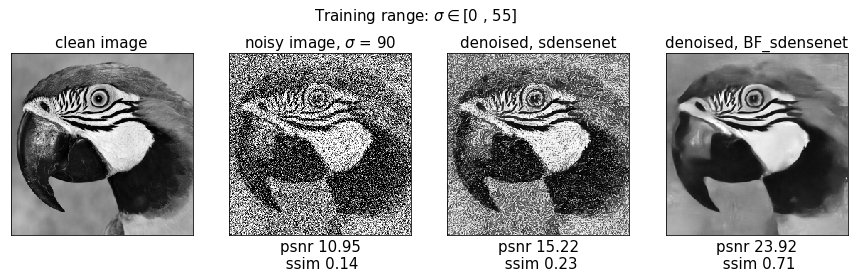

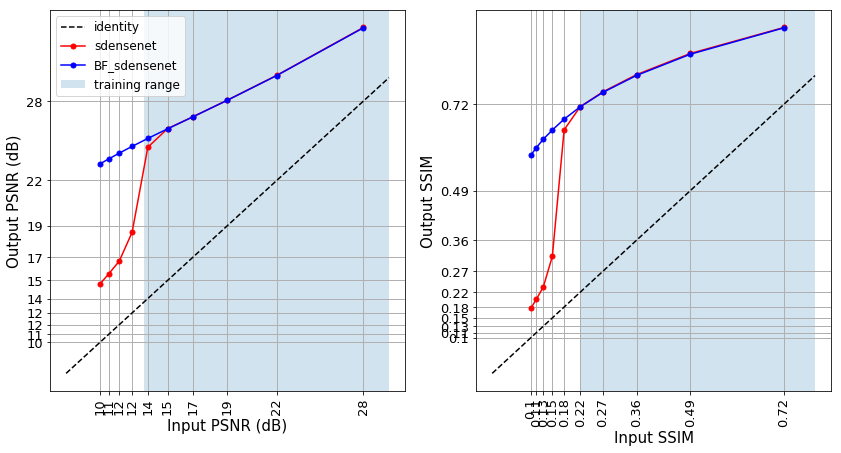

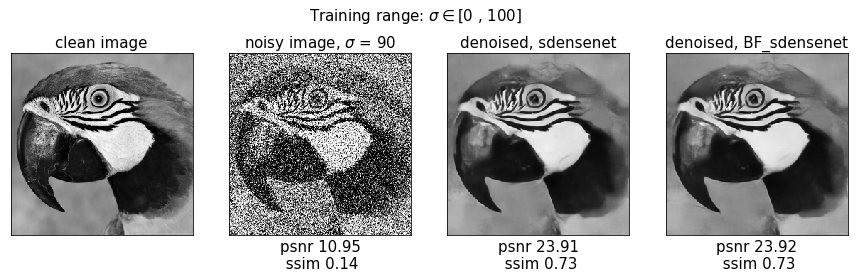

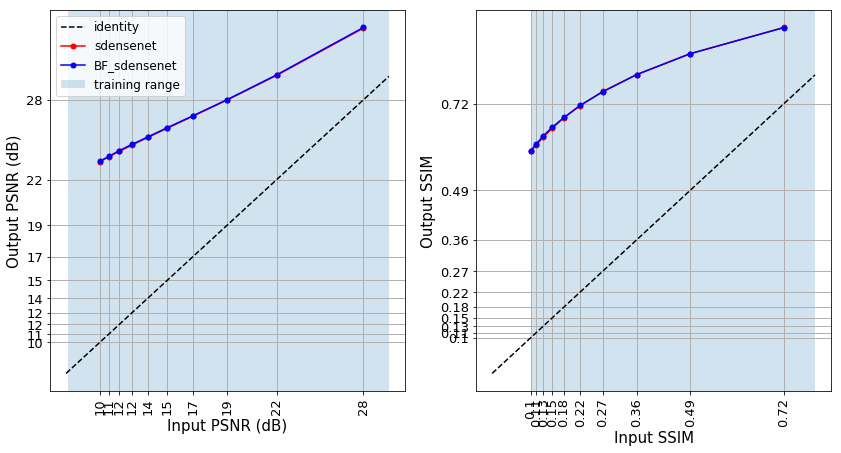

In [18]:

for max_noise in [10, 30, 55, 100]:
    CNN = load_model(os.path.join(pretrained_base, model, 'bias', str(min_noise)+'-'+str(max_noise)+'.pt'))
    BF_CNN = load_model(os.path.join(pretrained_base, model, 'bias_free', str(min_noise)+'-'+str(max_noise)+'.pt'))
    display_denoising(CNN, BF_CNN, set12_path, 
                          image_num=7, noise_level = 90, l = min_noise, h=max_noise, model = model);
    compute_and_plot_performance_plot(model, min_noise, max_noise)
    